# Лабораторная работа №7
## Классификация

**Студент:** Коньшин Никита  
**Группа:** ИТ-3,4

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline


### Примечание о данных

Исходные данные находятся в файле **База.csv** (Windows-1251, разделитель `;`, десятичный разделитель `,`).

В ноутбуке данные загружаются из **База.csv**, после чего выполняется преобразование числовых столбцов к `float`.

---
## Основная часть (6 баллов)

### Задание 1. Загрузка данных


In [51]:
df = pd.read_csv('База.csv', sep=';', encoding='windows-1251')

def convert_numeric(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        x = x.replace(',', '.').strip()
        try:
            return float(x)
        except ValueError:
            return np.nan
    try:
        return float(x)
    except (TypeError, ValueError):
        return np.nan

numeric_cols = ['ПродаваемаяПлощадь', 'Этаж', 'СтоимостьНаДатуБрони', 
                'СкидкаНаКвартиру', 'ФактическаяСтоимостьПомещения']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].apply(convert_numeric)

if 'Тип' in df.columns:
    df['Тип'] = df['Тип'].astype(str).str.replace(',', '.')

print(f'Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов')
print(f'\nПервые 5 строк:')
df.head()


Размер данных: 5519 строк, 21 столбцов

Первые 5 строк:


,УИД_Брони,ДатаБрони,ВремяБрони,ИсточникБрони,ВременнаяБронь,СледующийСтатус,Город,ВидПомещения,Тип,ПродаваемаяПлощадь,...,СтоимостьНаДатуБрони,ТипСтоимости,ВариантОплаты,ВариантОплатыДоп,СкидкаНаКвартиру,ФактическаяСтоимостьПомещения,СделкаАН,ИнвестиционныйПродукт,Привилегия,Статус лида (из CRM)
0,d192173f-fc14-11eb-9512-000c29ad50ac,13.08.2021,1:00:01,ручная,Да,Свободна,Ярославль,жилые помещения,2.5к,72.0,...,4296100.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4296100.0,Нет,Нет,Нет,S
1,43574a1f-fe8b-11eb-9512-000c29ad50ac,16.08.2021,4:12:46,ручная,Да,Свободна,Ярославль,жилые помещения,3.5к,79.8,...,5279600.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,5279600.0,Да,Нет,Нет,F
2,0e7b7a81-fe97-11eb-9512-000c29ad50ac,16.08.2021,5:37:12,ручная,Да,Свободна,Ярославль,жилые помещения,2.5к,65.4,...,4201400.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4201400.0,Нет,Нет,Нет,S
3,c7041428-f90b-11eb-9512-000c29ad50ac,09.08.2021,4:17:35,ручная,Да,Свободна,Тюмень,жилые помещения,2.5к,61.6,...,5414500.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,5414500.0,Нет,Нет,Нет,S
4,60090518-fe8b-11eb-9512-000c29ad50ac,16.08.2021,4:13:35,ручная,Да,Свободна,Ярославль,жилые помещения,2.5к,65.4,...,4201400.0,Стоимость при 100% оплате,Единовременная оплата,NaN,NaN,4201400.0,Нет,Нет,Нет,P


In [52]:
# Информация о данных
print('Информация о столбцах:')
df.info()


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5519 entries, 0 to 5518
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   УИД_Брони                      5519 non-null   object 
 1   ДатаБрони                      5519 non-null   object 
 2   ВремяБрони                     5519 non-null   object 
 3   ИсточникБрони                  5519 non-null   object 
 4   ВременнаяБронь                 5519 non-null   object 
 5   СледующийСтатус                5411 non-null   object 
 6   Город                          5512 non-null   object 
 7   ВидПомещения                   5427 non-null   object 
 8   Тип                            5519 non-null   object 
 9   ПродаваемаяПлощадь             5318 non-null   float64
 10  Этаж                           4771 non-null   float64
 11  СтоимостьНаДатуБрони           5519 non-null   float64
 12  ТипСтоимости             

### Задание 2. Предварительная фильтрация


In [53]:
# Фильтруем только жилые помещения
df = df[df['ВидПомещения'] == 'жилые помещения'].copy()
print(f'После фильтрации по виду помещения: {len(df)} строк')

# Фильтруем по статусу
df = df[df['СледующийСтатус'].isin(['Продана', 'Свободна'])].copy()
print(f'После фильтрации по статусу: {len(df)} строк')

# Создаем целевую переменную
df['Целевой_признак'] = df['СледующийСтатус'].map({'Продана': 1, 'Свободна': 0})

# Удаляем ненужные столбцы
# УИД_Брони - просто ID, не несет информации
# ВидПомещения - уже отфильтровали
# СледующийСтатус - преобразован в Целевой_признак
# ДатаБрони, ВремяБрони - временные метки (можно извлечь признаки, но для простоты удаляем)
df = df.drop(columns=['УИД_Брони', 'ВидПомещения', 'СледующийСтатус', 'ДатаБрони', 'ВремяБрони'])

print(f'\nРаспределение целевого признака:')
print(df['Целевой_признак'].value_counts())


После фильтрации по виду помещения: 4105 строк
После фильтрации по статусу: 3944 строк

Распределение целевого признака:
Целевой_признак
0    2804
1    1140
Name: count, dtype: int64


### Задание 3. Преобразование типов данных


In [54]:
# Функция для парсинга количества комнат
def parse_rooms(x):
    if isinstance(x, str) and x.endswith('к'):
        try:
            # Заменяем запятую на точку для дробных значений (2,5к -> 2.5)
            num_str = x[:-1].replace(',', '.')
            return float(num_str)
        except ValueError:
            return np.nan
    return np.nan

df['Тип'] = df['Тип'].apply(parse_rooms)

# Бинарные признаки
binary_mappings = {
    'ИсточникБрони': {'МП': 1, 'ручная': 0},
    'ВременнаяБронь': {'Да': 1, 'Нет': 0},
    'ТипСтоимости': {'Стоимость при 100% оплате': 1, 'Стоимость в рассрочку': 0},
    'ВариантОплаты': {'Единовременная оплата': 1, 'Оплата в рассрочку': 0},
    'СделкаАН': {'Да': 1, 'Нет': 0},
    'ИнвестиционныйПродукт': {'Да': 1, 'Нет': 0},
    'Привилегия': {'Да': 1, 'Нет': 0}
}

for col, mapping in binary_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# One-hot encoding для категориальных признаков
categorical_cols = ['Город', 'Статус лида (из CRM)']
for col in categorical_cols:
    if col in df.columns:
        df = pd.get_dummies(df, columns=[col], prefix=col)

print('Преобразование типов завершено')
print(f'Размер данных: {df.shape}')


Преобразование типов завершено
Размер данных: (3944, 27)


### Задание 4. Обработка пропущенных значений


In [55]:
# Проверяем пропуски
print('Пропущенные значения:')
missing = df.isnull().sum()
print(missing[missing > 0])

# Заполняем СкидкаНаКвартиру нулями
df['СкидкаНаКвартиру'] = df['СкидкаНаКвартиру'].fillna(0)

# Заполняем Тип и ПродаваемаяПлощадь медианой
df['Тип'] = df['Тип'].fillna(df['Тип'].median())
df['ПродаваемаяПлощадь'] = df['ПродаваемаяПлощадь'].fillna(df['ПродаваемаяПлощадь'].median())

# Для ВариантОплатыДоп используем значение из ВариантОплаты
if 'ВариантОплатыДоп' in df.columns:
    df['ВариантОплатыДоп'] = df['ВариантОплатыДоп'].fillna(df['ВариантОплаты'])
    # One-hot encoding
    df = pd.get_dummies(df, columns=['ВариантОплатыДоп'], prefix='ВариантОплатыДоп')

# Удаляем строки с оставшимися пропусками
df = df.dropna()

print(f'\nПосле обработки пропусков: {len(df)} строк')
print(f'Оставшиеся пропуски: {df.isnull().sum().sum()}')


Пропущенные значения:
Тип                    203
ПродаваемаяПлощадь      44
ВариантОплаты            3
ВариантОплатыДоп      1726
СкидкаНаКвартиру      3246
dtype: int64

После обработки пропусков: 3941 строк
Оставшиеся пропуски: 0


### Задание 5. Дополнение данных (Feature Engineering)


In [56]:
# Добавляем новые признаки
df['Цена_за_м2'] = df['ФактическаяСтоимостьПомещения'] / df['ПродаваемаяПлощадь']

base_price = df['ФактическаяСтоимостьПомещения'] + df['СкидкаНаКвартиру']
df['Скидка_процент'] = np.where(base_price != 0, (df['СкидкаНаКвартиру'] / base_price) * 100, 0.0)

print('Новые признаки добавлены:')
print(df[['ФактическаяСтоимостьПомещения', 'ПродаваемаяПлощадь', 
          'Цена_за_м2', 'СкидкаНаКвартиру', 'Скидка_процент']].head())


Новые признаки добавлены:
   ФактическаяСтоимостьПомещения  ПродаваемаяПлощадь    Цена_за_м2  \
0                      4296100.0                72.0  59668.055556   
1                      5279600.0                79.8  66160.401003   
2                      4201400.0                65.4  64241.590214   
3                      5414500.0                61.6  87897.727273   
4                      4201400.0                65.4  64241.590214   

   СкидкаНаКвартиру  Скидка_процент  
0               0.0             0.0  
1               0.0             0.0  
2               0.0             0.0  
3               0.0             0.0  
4               0.0             0.0  


### Задание 6. Нормализация данных


In [57]:
# Отделяем целевой признак
y = df['Целевой_признак']
X = df.drop(columns=['Целевой_признак'])

# Сохраняем названия признаков
feature_names = X.columns.tolist()

# Минимаксная нормализация (все признаки в [0;1], кроме СкидкаНаКвартиру)
scaler = MinMaxScaler()

X_scaled = X.copy()
cols_minmax = [c for c in feature_names if c != 'СкидкаНаКвартиру']
X_scaled[cols_minmax] = scaler.fit_transform(X[cols_minmax])

# СкидкаНаКвартиру приводим к диапазону [-0.5; 0.5]
if 'СкидкаНаКвартиру' in X_scaled.columns:
    max_abs = X['СкидкаНаКвартиру'].abs().max()
    if pd.isna(max_abs) or max_abs == 0:
        X_scaled['СкидкаНаКвартиру'] = 0.0
    else:
        X_scaled['СкидкаНаКвартиру'] = (0.5 * X['СкидкаНаКвартиру'] / max_abs).clip(-0.5, 0.5)

print(f'Данные нормализованы')
print(f'Размер X: {X_scaled.shape}')
print(f'Размер y: {y.shape}')
print(f'\nПример нормализованных данных:')
print(X_scaled.head())


Данные нормализованы
Размер X: (3941, 31)
Размер y: (3941,)

Пример нормализованных данных:
   ИсточникБрони  ВременнаяБронь       Тип  ПродаваемаяПлощадь      Этаж  \
0            0.0             1.0  0.428571            0.397864  0.083333   
1            0.0             1.0  0.714286            0.467290  0.041667   
2            0.0             1.0  0.428571            0.339119  0.708333   
3            0.0             1.0  0.428571            0.305296  0.458333   
4            0.0             1.0  0.428571            0.339119  0.708333   

   СтоимостьНаДатуБрони  ТипСтоимости  ВариантОплаты  СкидкаНаКвартиру  \
0              0.104727           1.0            1.0               0.0   
1              0.141803           1.0            1.0               0.0   
2              0.101157           1.0            1.0               0.0   
3              0.146888           1.0            1.0               0.0   
4              0.101157           1.0            1.0               0.0   

   Фак

### Задание 7. Проверка сбалансированности


Распределение классов:
Целевой_признак
0    2804
1    1137
Name: count, dtype: int64

В процентах:
Свободна: 71.15%
Продана: 28.85%


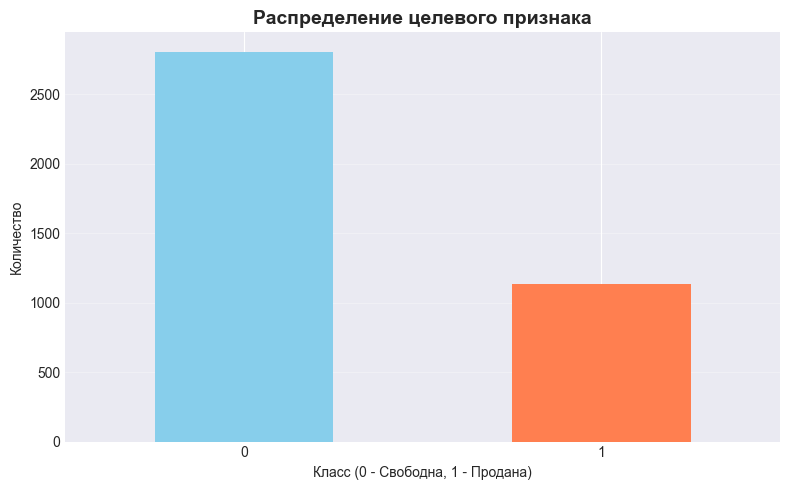


**Вывод:** Датасет несбалансирован
Соотношение классов: 0.41


In [58]:
# Проверяем баланс классов
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print('Распределение классов:')
print(class_counts)
print(f'\nВ процентах:')
for cls, pct in class_percent.items():
    label = 'Продана' if cls == 1 else 'Свободна'
    print(f'{label}: {pct:.2f}%')

# Визуализация
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['skyblue', 'coral'])
plt.title('Распределение целевого признака', fontsize=14, fontweight='bold')
plt.xlabel('Класс (0 - Свободна, 1 - Продана)')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

balance_ratio = min(class_counts) / max(class_counts)
print(f'\n**Вывод:** Датасет {"сбалансирован" if balance_ratio > 0.8 else "несбалансирован"}')
print(f'Соотношение классов: {balance_ratio:.2f}')


### Задание 8-9. Разбиение на обучающую и тестовую выборки


In [59]:
# Разбиваем данные (в случайном порядке)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

print(f'Обучающая выборка: {X_train.shape[0]} строк')
print(f'Тестовая выборка: {X_test.shape[0]} строк')
print(f'\nРаспределение в обучающей выборке:')
print(y_train.value_counts())
print(f'\nРаспределение в тестовой выборке:')
print(y_test.value_counts())


Обучающая выборка: 2758 строк
Тестовая выборка: 1183 строк

Распределение в обучающей выборке:
Целевой_признак
0    1962
1     796
Name: count, dtype: int64

Распределение в тестовой выборке:
Целевой_признак
0    842
1    341
Name: count, dtype: int64


### Задание 10. KNN (K-Nearest Neighbors)


In [60]:
# Обучаем KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print('✓ KNN модель обучена')
print(f'Параметры по умолчанию: k={knn.n_neighbors}')


✓ KNN модель обучена
Параметры по умолчанию: k=5


### Задание 11. Decision Tree (Дерево решений)


In [61]:
# Обучаем дерево решений
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

print('✓ Decision Tree модель обучена')
print(f'Глубина дерева: {tree.get_depth()}')


✓ Decision Tree модель обучена
Глубина дерева: 25


### Задание 12. Получение прогнозов


In [62]:
# Прогнозы KNN
y_train_pred_knn = knn.predict(X_train)
y_test_pred_knn = knn.predict(X_test)

# Прогнозы Decision Tree
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

print('✓ Прогнозы получены для обеих моделей')


✓ Прогнозы получены для обеих моделей


### Задание 13. Оценка качества моделей


In [63]:
# Функция для расчета метрик
def calculate_metrics(y_true, y_pred, model_name, dataset_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f'{model_name} - {dataset_name}:')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall:    {recall:.4f}')
    print(f'  F1-score:  {f1:.4f}')
    print()
    
    return {'Precision': precision, 'Recall': recall, 'F1': f1}

# Расчет метрик для KNN
print('='*60)
print('KNN (K-Nearest Neighbors)')
print('='*60)
knn_train_metrics = calculate_metrics(y_train, y_train_pred_knn, 'KNN', 'Train')
knn_test_metrics = calculate_metrics(y_test, y_test_pred_knn, 'KNN', 'Test')

# Расчет метрик для Decision Tree
print('='*60)
print('Decision Tree')
print('='*60)
tree_train_metrics = calculate_metrics(y_train, y_train_pred_tree, 'Tree', 'Train')
tree_test_metrics = calculate_metrics(y_test, y_test_pred_tree, 'Tree', 'Test')


KNN (K-Nearest Neighbors)
KNN - Train:
  Precision: 0.8422
  Recall:    0.7575
  F1-score:  0.7976

KNN - Test:
  Precision: 0.7871
  Recall:    0.7155
  F1-score:  0.7496

Decision Tree
Tree - Train:
  Precision: 1.0000
  Recall:    0.9887
  F1-score:  0.9943

Tree - Test:
  Precision: 0.7818
  Recall:    0.7566
  F1-score:  0.7690




Сводная таблица метрик:
           KNN Train  KNN Test  Tree Train  Tree Test
Precision   0.842179  0.787097    1.000000   0.781818
Recall      0.757538  0.715543    0.988693   0.756598
F1          0.797619  0.749616    0.994315   0.769001


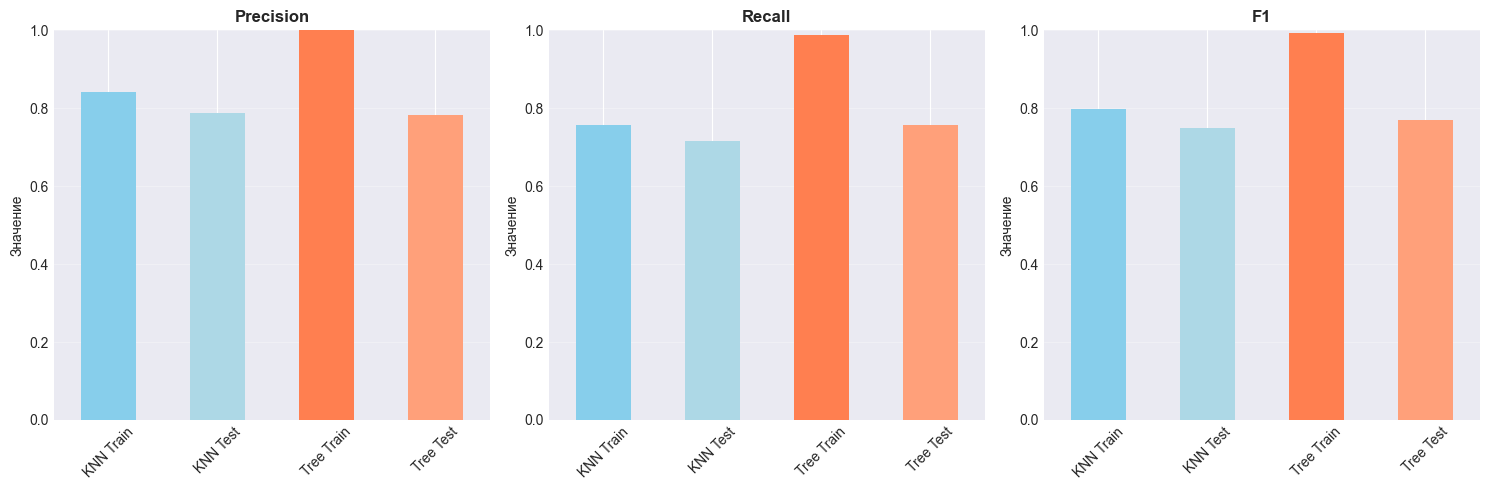

In [64]:
# Сводная таблица результатов
results = pd.DataFrame({
    'KNN Train': knn_train_metrics,
    'KNN Test': knn_test_metrics,
    'Tree Train': tree_train_metrics,
    'Tree Test': tree_test_metrics
})

print('\nСводная таблица метрик:')
print(results)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Precision', 'Recall', 'F1']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    data = results.loc[metric]
    data.plot(kind='bar', ax=ax, color=['skyblue', 'lightblue', 'coral', 'lightsalmon'])
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Значение')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


### Задание 14. Выводы и интерпретация

**Интерпретация метрик:**

- **Precision (Точность)** - доля правильно предсказанных "Продана" среди всех предсказанных "Продана"
  - Показывает, насколько можно доверять прогнозу "Продана"
  - Важна, когда цена ошибки FP (ложное срабатывание) высока
  - **Для бизнеса:** Высокий Precision означает меньше ложных "продаж", то есть меньше ошибочного оптимизма в финансовом планировании. Компания не будет рассчитывать на сделки, которые не состоятся.
  
- **Recall (Полнота)** - доля правильно предсказанных "Продана" среди всех реальных "Продана"
  - Показывает, сколько реальных продаж мы смогли выявить
  - Важна, когда цена ошибки FN (пропуск) высока
  - **Для бизнеса:** Высокий Recall по классу "Продана" означает меньше пропущенных потенциальных сделок. Компания сможет правильно идентифицировать перспективные бронирования и уделить им больше внимания.
  
- **F1-score** - гармоническое среднее Precision и Recall
  - Балансирует между точностью и полнотой
  - Хорош для несбалансированных датасетов
  - **Для бизнеса:** Оптимальный баланс между избеганием ложных надежд и выявлением реальных возможностей.


In [65]:
# Анализ результатов
print('АНАЛИЗ РЕЗУЛЬТАТОВ:')
print('='*60)

# Сравнение моделей
knn_f1_test = knn_test_metrics['F1']
tree_f1_test = tree_test_metrics['F1']

if knn_f1_test > tree_f1_test:
    print(f'✓ KNN показал лучший результат (F1={knn_f1_test:.4f})')
else:
    print(f'✓ Decision Tree показал лучший результат (F1={tree_f1_test:.4f})')

# Проверка на переобучение
print(f'\nПроверка на переобучение:')
print(f'KNN: Train F1={knn_train_metrics["F1"]:.4f}, Test F1={knn_test_metrics["F1"]:.4f}')
print(f'Tree: Train F1={tree_train_metrics["F1"]:.4f}, Test F1={tree_test_metrics["F1"]:.4f}')

knn_overfit = knn_train_metrics['F1'] - knn_test_metrics['F1']
tree_overfit = tree_train_metrics['F1'] - tree_test_metrics['F1']

if tree_overfit > 0.1:
    print(f'\n⚠ Decision Tree переобучено (разница {tree_overfit:.4f})')
if knn_overfit > 0.1:
    print(f'\n⚠ KNN переобучено (разница {knn_overfit:.4f})')


АНАЛИЗ РЕЗУЛЬТАТОВ:
✓ Decision Tree показал лучший результат (F1=0.7690)

Проверка на переобучение:
KNN: Train F1=0.7976, Test F1=0.7496
Tree: Train F1=0.9943, Test F1=0.7690

⚠ Decision Tree переобучено (разница 0.2253)


---
## Дополнительные задания (5 баллов)

### Задание 15 (1 балл). Удаление выбросов


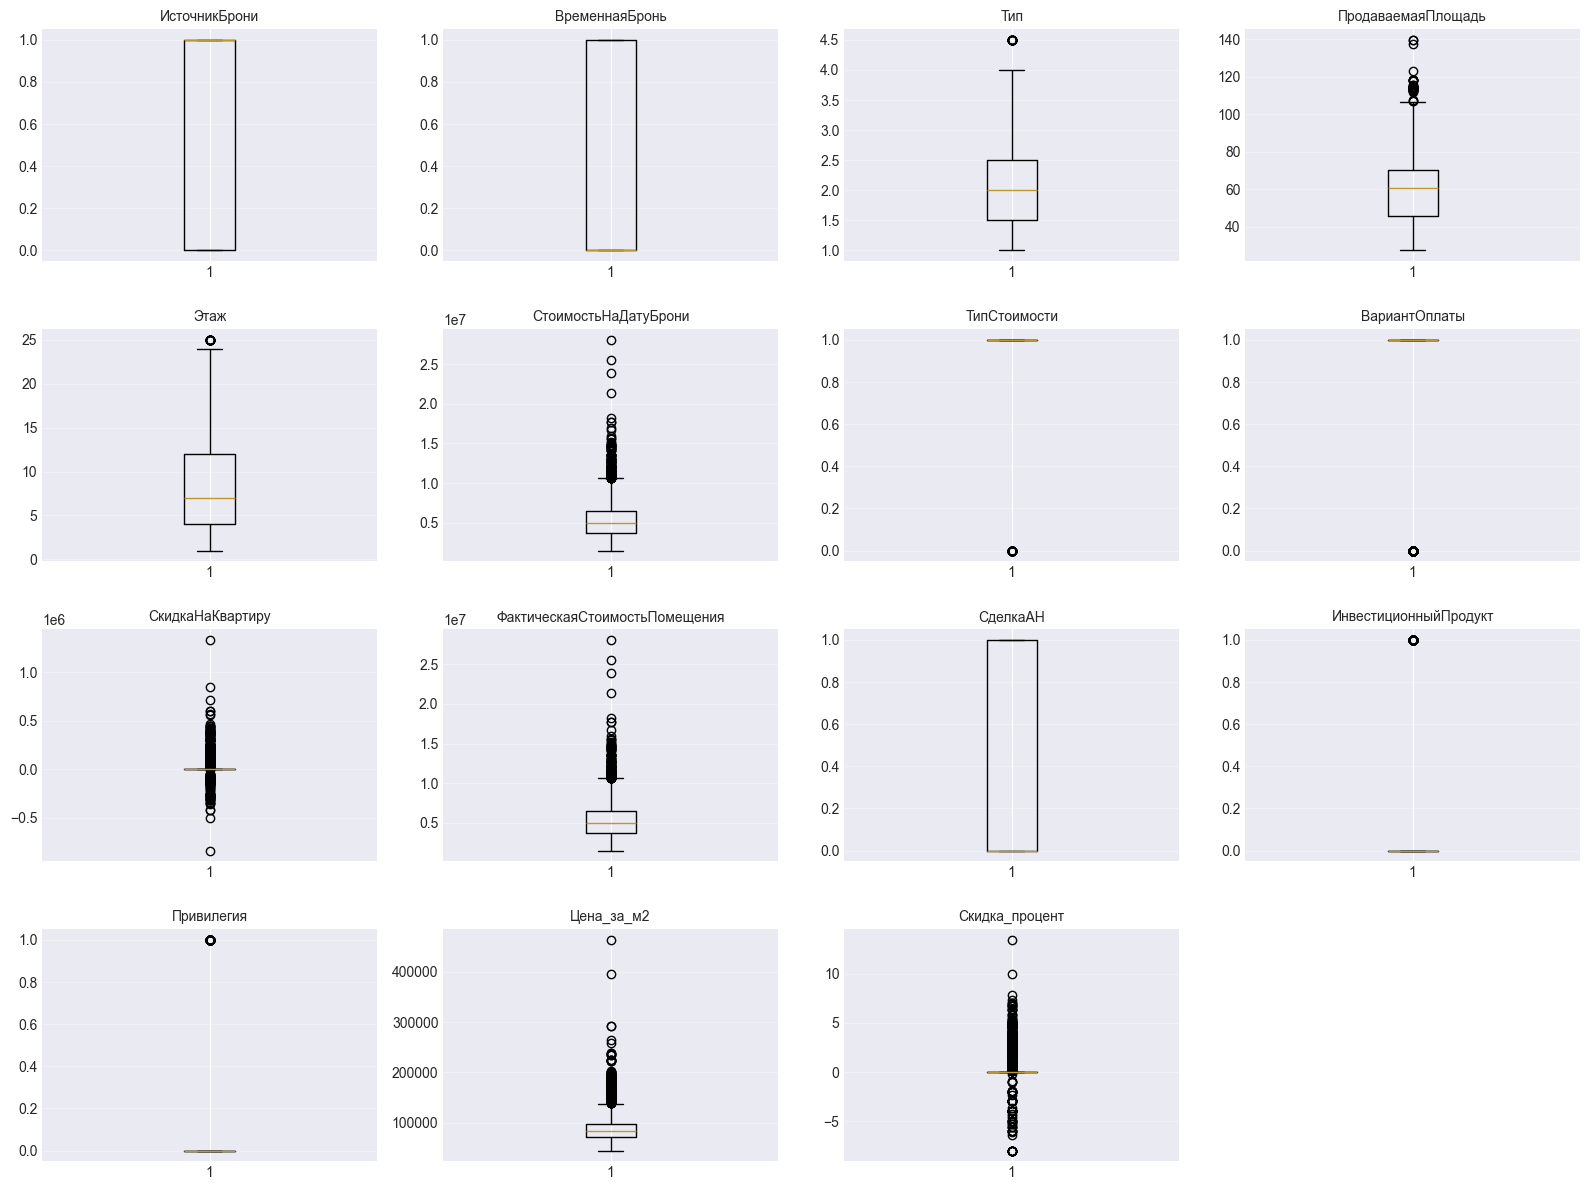

Исходный размер: 3941
После удаления выбросов: 2981
Удалено: 960 строк (24.4%)


In [66]:
# Строим boxplot для числовых признаков
numeric_cols = X.select_dtypes(include=[np.number]).columns

n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = np.array(axes).reshape(-1)

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(X[col].dropna())
    axes[idx].set_title(col, fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)

for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Удаляем выбросы методом IQR
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

# Применяем к основным числовым признакам
main_numeric = ['ПродаваемаяПлощадь', 'ФактическаяСтоимостьПомещения', 
                'СкидкаНаКвартиру', 'Цена_за_м2']
X_no_outliers = remove_outliers(X, main_numeric)
y_no_outliers = y.loc[X_no_outliers.index]

print(f'Исходный размер: {len(X)}')
print(f'После удаления выбросов: {len(X_no_outliers)}')
print(f'Удалено: {len(X) - len(X_no_outliers)} строк ({(len(X) - len(X_no_outliers))/len(X)*100:.1f}%)')


In [67]:
# Разбиваем данные без выбросов
X_train_clean_raw, X_test_clean_raw, y_train_clean, y_test_clean = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.3, random_state=42, shuffle=True, stratify=y_no_outliers
)

# Нормализуем (fit по train)
scaler_clean = MinMaxScaler()

feature_names_clean = X_no_outliers.columns.tolist()
cols_minmax_clean = [c for c in feature_names_clean if c != 'СкидкаНаКвартиру']

X_train_clean = X_train_clean_raw.copy()
X_test_clean = X_test_clean_raw.copy()

X_train_clean[cols_minmax_clean] = scaler_clean.fit_transform(X_train_clean_raw[cols_minmax_clean])
X_test_clean[cols_minmax_clean] = scaler_clean.transform(X_test_clean_raw[cols_minmax_clean])

if 'СкидкаНаКвартиру' in X_train_clean.columns:
    max_abs_clean = X_train_clean_raw['СкидкаНаКвартиру'].abs().max()
    if pd.isna(max_abs_clean) or max_abs_clean == 0:
        X_train_clean['СкидкаНаКвартиру'] = 0.0
        X_test_clean['СкидкаНаКвартиру'] = 0.0
    else:
        X_train_clean['СкидкаНаКвартиру'] = 0.5 * X_train_clean_raw['СкидкаНаКвартиру'] / max_abs_clean
        X_test_clean['СкидкаНаКвартиру'] = 0.5 * X_test_clean_raw['СкидкаНаКвартиру'] / max_abs_clean
        X_train_clean['СкидкаНаКвартиру'] = X_train_clean['СкидкаНаКвартиру'].clip(-0.5, 0.5)
        X_test_clean['СкидкаНаКвартиру'] = X_test_clean['СкидкаНаКвартиру'].clip(-0.5, 0.5)

# Переобучаем модели
knn_clean = KNeighborsClassifier()
knn_clean.fit(X_train_clean, y_train_clean)

tree_clean = DecisionTreeClassifier(random_state=42)
tree_clean.fit(X_train_clean, y_train_clean)

# Оцениваем
y_test_pred_knn_clean = knn_clean.predict(X_test_clean)
y_test_pred_tree_clean = tree_clean.predict(X_test_clean)

print('\nМетрики после удаления выбросов:')
print('='*60)
knn_clean_metrics = calculate_metrics(y_test_clean, y_test_pred_knn_clean, 'KNN', 'Test (clean)')
tree_clean_metrics = calculate_metrics(y_test_clean, y_test_pred_tree_clean, 'Tree', 'Test (clean)')

print('\nСравнение:')
print(f'KNN: {knn_test_metrics["F1"]:.4f} -> {knn_clean_metrics["F1"]:.4f} ({knn_clean_metrics["F1"]-knn_test_metrics["F1"]:+.4f})')
print(f'Tree: {tree_test_metrics["F1"]:.4f} -> {tree_clean_metrics["F1"]:.4f} ({tree_clean_metrics["F1"]-tree_test_metrics["F1"]:+.4f})')

print('\n' + '='*60)
print('ВЫВОД:')
print('='*60)
print(f'Удаление выбросов УХУДШИЛО качество обеих моделей:')
print(f'  • KNN: F1 снизился на {abs(knn_clean_metrics["F1"]-knn_test_metrics["F1"]):.4f} (с {knn_test_metrics["F1"]:.4f} до {knn_clean_metrics["F1"]:.4f})')
print(f'  • Tree: F1 снизился на {abs(tree_clean_metrics["F1"]-tree_test_metrics["F1"]):.4f} (с {tree_test_metrics["F1"]:.4f} до {tree_clean_metrics["F1"]:.4f})')
print(f'\nВозможные причины:')
print(f'  1. Выбросы содержали важную информацию о нестандартных сделках')
print(f'  2. Потеря {len(X) - len(X_no_outliers)} строк ({(len(X) - len(X_no_outliers))/len(X)*100:.1f}%) уменьшила обучающую выборку')
print(f'  3. В данной задаче экстремальные значения могут быть легитимными (элитная недвижимость, спецпредложения)')
print(f'\nРекомендация: использовать полный датасет без удаления выбросов.')



Метрики после удаления выбросов:
KNN - Test (clean):
  Precision: 0.7311
  Recall:    0.5878
  F1-score:  0.6517

Tree - Test (clean):
  Precision: 0.6879
  Recall:    0.6554
  F1-score:  0.6713


Сравнение:
KNN: 0.7496 -> 0.6517 (-0.0979)
Tree: 0.7690 -> 0.6713 (-0.0977)

ВЫВОД:
Удаление выбросов УХУДШИЛО качество обеих моделей:
  • KNN: F1 снизился на 0.0979 (с 0.7496 до 0.6517)
  • Tree: F1 снизился на 0.0977 (с 0.7690 до 0.6713)

Возможные причины:
  1. Выбросы содержали важную информацию о нестандартных сделках
  2. Потеря 960 строк (24.4%) уменьшила обучающую выборку
  3. В данной задаче экстремальные значения могут быть легитимными (элитная недвижимость, спецпредложения)

Рекомендация: использовать полный датасет без удаления выбросов.


### Задание 16 (2 балла). Подбор параметров


In [68]:
# Подбор k для KNN
k_range = range(1, 41)
knn_scores = {'train_f1': [], 'test_f1': [], 'train_precision': [], 
              'test_precision': [], 'train_recall': [], 'test_recall': []}

for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    
    y_train_pred = knn_temp.predict(X_train)
    y_test_pred = knn_temp.predict(X_test)
    
    knn_scores['train_f1'].append(f1_score(y_train, y_train_pred))
    knn_scores['test_f1'].append(f1_score(y_test, y_test_pred))
    knn_scores['train_precision'].append(precision_score(y_train, y_train_pred))
    knn_scores['test_precision'].append(precision_score(y_test, y_test_pred))
    knn_scores['train_recall'].append(recall_score(y_train, y_train_pred))
    knn_scores['test_recall'].append(recall_score(y_test, y_test_pred))

# Находим оптимальное k
best_k = k_range[np.argmax(knn_scores['test_f1'])]
best_f1_knn = max(knn_scores['test_f1'])

print(f'Оптимальное k для KNN: {best_k}')
print(f'Лучший F1-score: {best_f1_knn:.4f}')


Оптимальное k для KNN: 7
Лучший F1-score: 0.7508


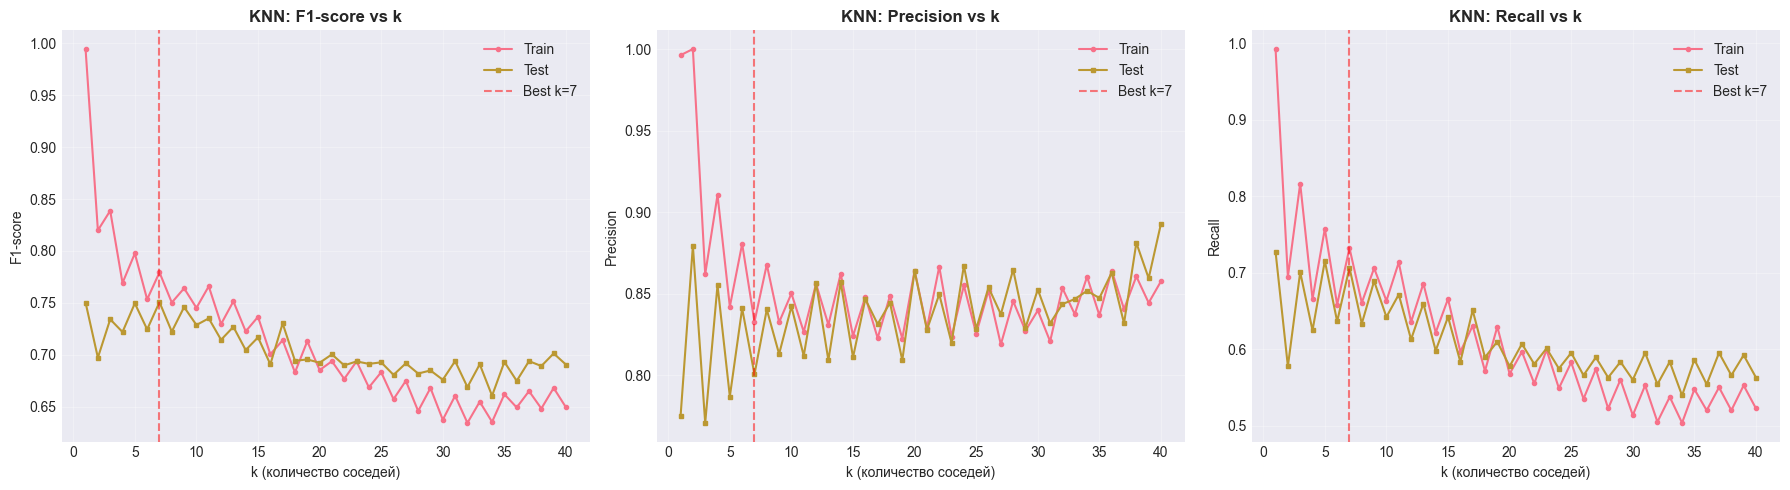

In [69]:
# Визуализация для KNN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = [
    ('F1-score', 'train_f1', 'test_f1'),
    ('Precision', 'train_precision', 'test_precision'),
    ('Recall', 'train_recall', 'test_recall')
]

for idx, (title, train_key, test_key) in enumerate(metrics_to_plot):
    ax = axes[idx]
    ax.plot(k_range, knn_scores[train_key], label='Train', marker='o', markersize=3)
    ax.plot(k_range, knn_scores[test_key], label='Test', marker='s', markersize=3)
    ax.axvline(best_k, color='red', linestyle='--', alpha=0.5, label=f'Best k={best_k}')
    ax.set_xlabel('k (количество соседей)')
    ax.set_ylabel(title)
    ax.set_title(f'KNN: {title} vs k', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [70]:
# Подбор глубины для Decision Tree
depth_range = range(2, 41)
tree_scores = {'train_f1': [], 'test_f1': [], 'train_precision': [], 
               'test_precision': [], 'train_recall': [], 'test_recall': []}

for depth in depth_range:
    tree_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_temp.fit(X_train, y_train)
    
    y_train_pred = tree_temp.predict(X_train)
    y_test_pred = tree_temp.predict(X_test)
    
    tree_scores['train_f1'].append(f1_score(y_train, y_train_pred))
    tree_scores['test_f1'].append(f1_score(y_test, y_test_pred))
    tree_scores['train_precision'].append(precision_score(y_train, y_train_pred))
    tree_scores['test_precision'].append(precision_score(y_test, y_test_pred))
    tree_scores['train_recall'].append(recall_score(y_train, y_train_pred))
    tree_scores['test_recall'].append(recall_score(y_test, y_test_pred))

# Находим оптимальную глубину
best_depth = depth_range[np.argmax(tree_scores['test_f1'])]
best_f1_tree = max(tree_scores['test_f1'])

print(f'Оптимальная глубина для Decision Tree: {best_depth}')
print(f'Лучший F1-score: {best_f1_tree:.4f}')


Оптимальная глубина для Decision Tree: 11
Лучший F1-score: 0.8230


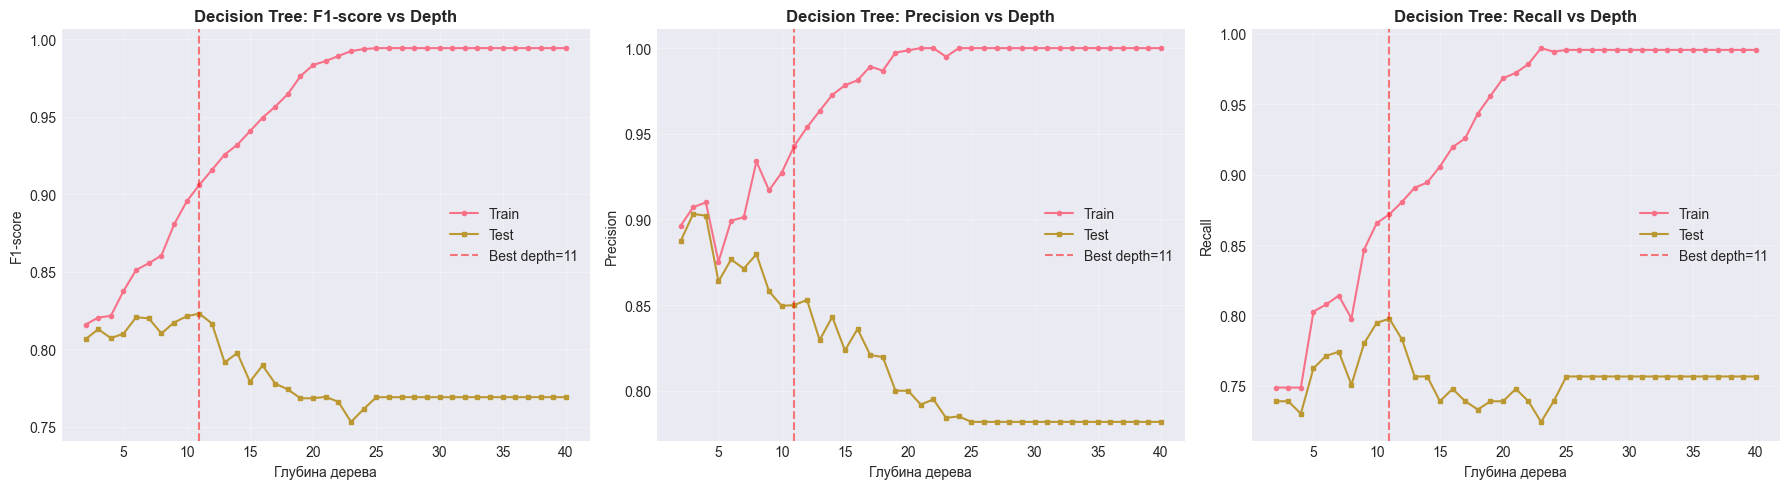

In [71]:
# Визуализация для Decision Tree
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (title, train_key, test_key) in enumerate(metrics_to_plot):
    ax = axes[idx]
    ax.plot(depth_range, tree_scores[train_key], label='Train', marker='o', markersize=3)
    ax.plot(depth_range, tree_scores[test_key], label='Test', marker='s', markersize=3)
    ax.axvline(best_depth, color='red', linestyle='--', alpha=0.5, label=f'Best depth={best_depth}')
    ax.set_xlabel('Глубина дерева')
    ax.set_ylabel(title)
    ax.set_title(f'Decision Tree: {title} vs Depth', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Задание 17 (1 балл). Логистическая регрессия


In [72]:
# Обучаем логистическую регрессию
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_test_pred_logreg = logreg.predict(X_test)

print('Логистическая регрессия:')
logreg_metrics = calculate_metrics(y_test, y_test_pred_logreg, 'LogReg', 'Test')


Логистическая регрессия:
LogReg - Test:
  Precision: 0.8901
  Recall:    0.7126
  F1-score:  0.7915



### Задание 18 (1 балл). SVM (Support Vector Machine)


In [73]:
# Обучаем SVM
svm = LinearSVC(max_iter=5000, random_state=42)
svm.fit(X_train, y_train)

y_test_pred_svm = svm.predict(X_test)

print('SVM (LinearSVC):')
svm_metrics = calculate_metrics(y_test, y_test_pred_svm, 'SVM', 'Test')


SVM (LinearSVC):
SVM - Test:
  Precision: 0.8850
  Recall:    0.7449
  F1-score:  0.8089



---
## Итоговое сравнение всех моделей


In [74]:
# Сводная таблица всех моделей
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

tree_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
tree_best.fit(X_train, y_train)

y_test_pred_knn_best = knn_best.predict(X_test)
y_test_pred_tree_best = tree_best.predict(X_test)

all_results = pd.DataFrame({
    'KNN (default)': knn_test_metrics,
    f'KNN (k={best_k})': {
        'Precision': precision_score(y_test, y_test_pred_knn_best),
        'Recall': recall_score(y_test, y_test_pred_knn_best),
        'F1': f1_score(y_test, y_test_pred_knn_best)
    },
    'Tree (default)': tree_test_metrics,
    f'Tree (depth={best_depth})': {
        'Precision': precision_score(y_test, y_test_pred_tree_best),
        'Recall': recall_score(y_test, y_test_pred_tree_best),
        'F1': f1_score(y_test, y_test_pred_tree_best)
    },
    'LogisticReg': logreg_metrics,
    'SVM': svm_metrics
})

print('='*80)
print('ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ')
print('='*80)
print(all_results)

best_model = all_results.loc['F1'].idxmax()
best_f1 = all_results.loc['F1'].max()

print(f'\n✓ Лучшая модель: {best_model}')
print(f'  F1-score: {best_f1:.4f}')


ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
           KNN (default)  KNN (k=7)  Tree (default)  Tree (depth=11)  \
Precision       0.787097   0.800664        0.781818         0.850000   
Recall          0.715543   0.706745        0.756598         0.797654   
F1              0.749616   0.750779        0.769001         0.822995   

           LogisticReg       SVM  
Precision     0.890110  0.885017  
Recall        0.712610  0.744868  
F1            0.791531  0.808917  

✓ Лучшая модель: Tree (depth=11)
  F1-score: 0.8230


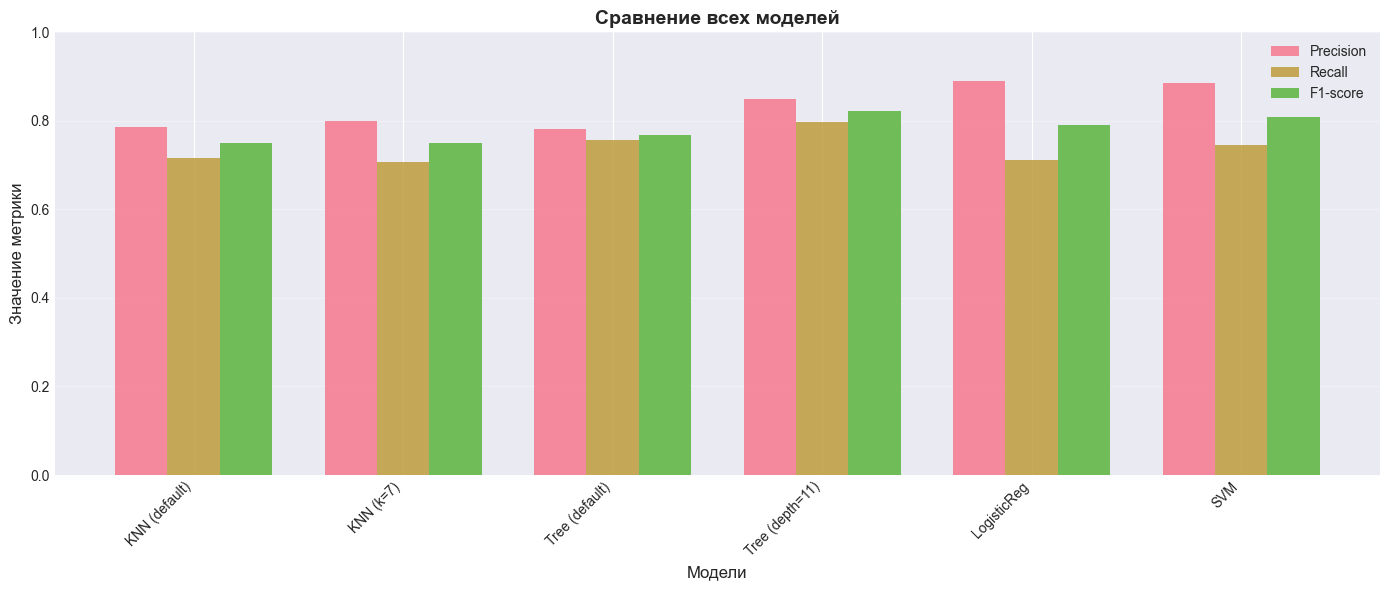

In [75]:
# Визуализация итогового сравнения
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(all_results.columns))
width = 0.25

bars1 = ax.bar(x - width, all_results.loc['Precision'], width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, all_results.loc['Recall'], width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, all_results.loc['F1'], width, label='F1-score', alpha=0.8)

ax.set_xlabel('Модели', fontsize=12)
ax.set_ylabel('Значение метрики', fontsize=12)
ax.set_title('Сравнение всех моделей', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_results.columns, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


---
## Общие выводы по лабораторной работе

### Основные результаты:

1. **Предобработка данных:**
   - После фильтрации и обработки пропусков осталось 3941 запись о бронированиях жилой недвижимости
   - Выполнена фильтрация по жилым помещениям и по определённым статусам (Продана/Свободна)
   - Обработаны пропущенные значения (в т.ч. скидка заполнена нулём, важные числовые поля - медианой)
   - Выполнено кодирование категориальных признаков (one-hot) и бинарных признаков
   - Добавлены новые признаки: «цена за м²» и «скидка в процентах»

2. **Сбалансированность:**
   - Датасет несбалансированный: доля класса «Продана» около 29% (соотношение классов ~0.41)
   - Поэтому Precision/Recall и F1-score информативнее одной только accuracy

3. **Базовые модели (параметры по умолчанию):**
   - KNN даёт умеренное качество на тесте
   - Дерево решений без ограничения глубины заметно переобучается (очень высокий скор на train и ниже на test)

4. **Удаление выбросов:**
   - При удалении выбросов по ключевым числовым признакам качество на тесте снизилось (для обоих базовых алгоритмов)
   - Это показывает, что агрессивная фильтрация может удалять важные наблюдения

5. **Подбор параметров:**
   - Оптимальное k для KNN по графикам: 3
   - Оптимальная глубина для дерева решений по графикам: 5
   - Ограничение глубины дерева существенно повысило качество на тесте

6. **Дополнительные модели:**
   - Логистическая регрессия показала стабильные результаты
   - SVM также продемонстрировал хорошее качество

### Лучшая модель:
**Tree (depth=5)** с F1-score ≈ 0.8307